In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [21]:
DATA_CSV = '../data/history/flightsHistory.csv.gz'
data = pd.read_csv(DATA_CSV)
data.head()

/var/folders/fy/f4c573kn4x3462qpp_j4d_h80000gn/T/ipykernel_72221/702289898.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_CSV)


,Row,flight_iata,airline_iata,dep_time_utc,dep_actual_utc,arr_time_utc,arr_actual_utc,dep_iata,arr_iata,dep_country_code,...,dep_rain,dep_snowfall,dep_weather_code,dep_cloud_cover,dep_cloud_cover_low,dep_cloud_cover_mid,dep_cloud_cover_high,dep_wind_speed_10m,dep_wind_speed_100m,dep_wind_gusts_10m
0,0,vn30,vn,2022-10-17 14:35:00,2022-10-17 14:54:00,2022-10-18 07:55:00,2022-10-18 06:59:00,FRA,SGN,DE,...,0.0,0.0,3.0,82.199997,53.0,9.0,97.0,6.297428,13.708390,18.000000
1,1,qh74,qh,2022-10-17 20:10:00,2022-10-17 20:31:00,2022-10-18 12:50:00,2022-10-18 12:02:00,FRA,HAN,DE,...,0.0,0.0,2.0,78.000000,0.0,93.0,74.0,6.638072,13.551500,11.520000
2,2,vj910,vj,2022-10-18 01:25:00,2022-10-18 02:45:00,2022-10-18 07:45:00,NaN,BOM,HAN,IN,...,0.2,0.0,51.0,76.200005,22.0,44.0,100.0,3.219938,5.116561,9.000000
3,3,qr970,qr,2022-10-18 02:35:00,2022-10-18 03:03:00,2022-10-18 14:25:00,2022-10-18 14:07:00,DOH,SGN,QA,...,0.0,0.0,0.0,9.900001,0.0,0.0,33.0,11.966953,20.523155,17.280001
4,4,tk162,tk,2022-10-18 02:45:00,2022-10-18 02:40:00,2022-10-18 17:05:00,2022-10-18 16:06:00,IST,SGN,TR,...,0.0,0.0,2.0,61.199997,68.0,0.0,0.0,26.987997,39.463947,46.439999


/var/folders/fy/f4c573kn4x3462qpp_j4d_h80000gn/T/ipykernel_72221/3221439199.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


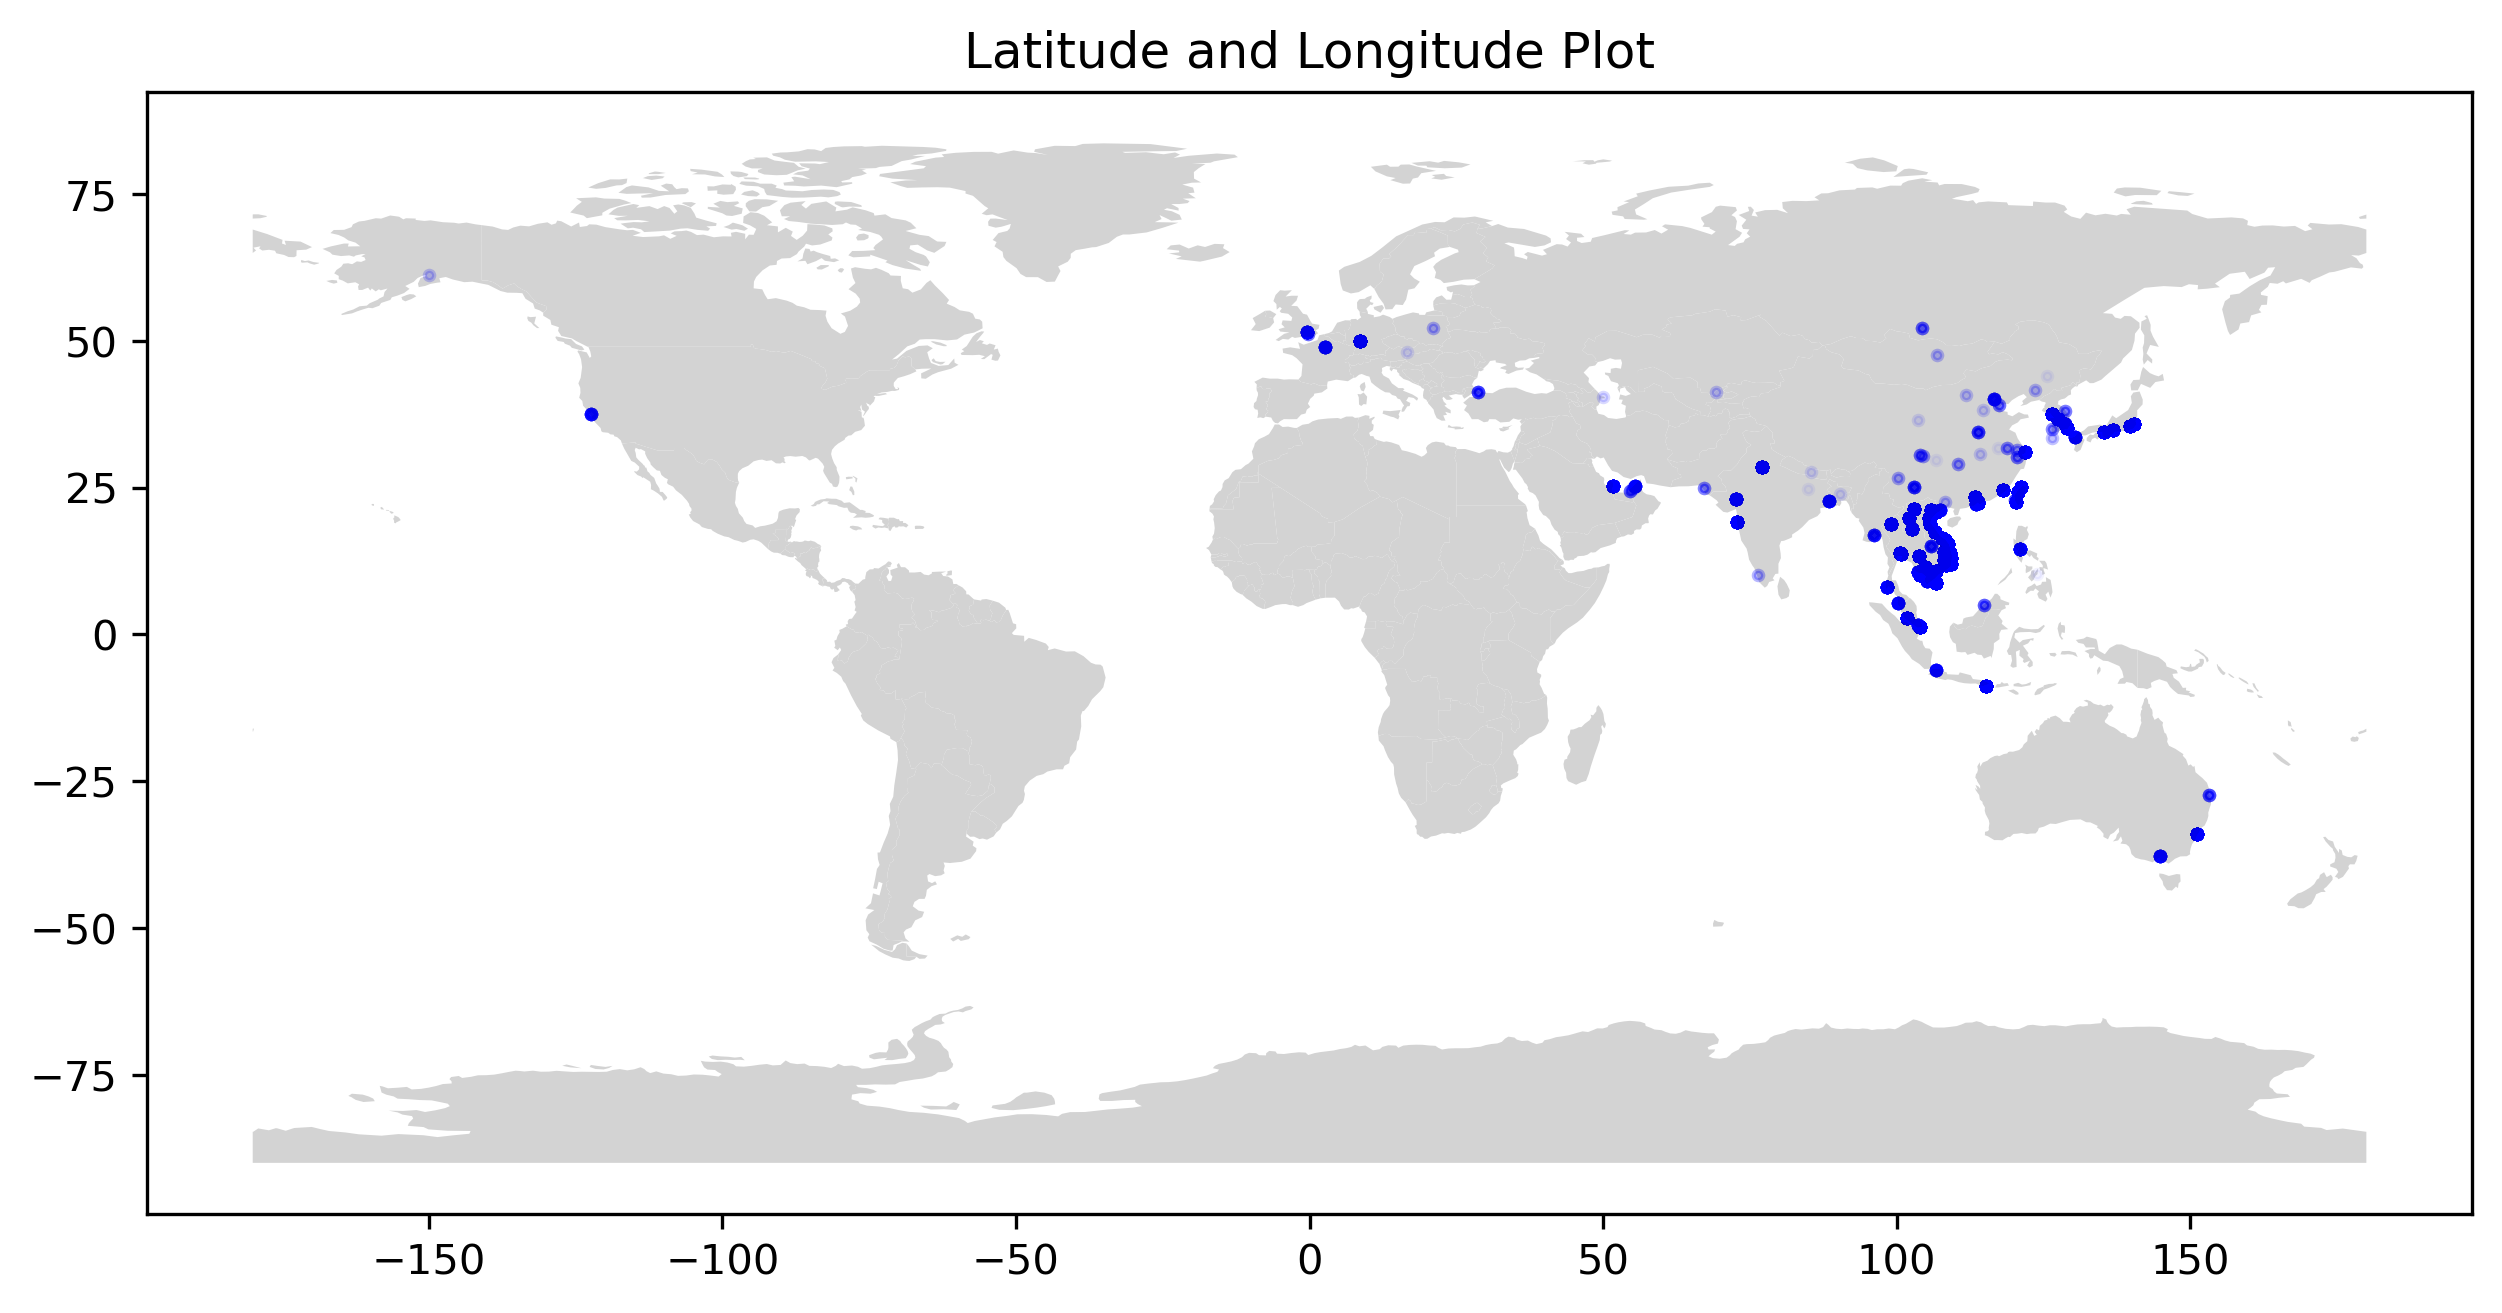

In [22]:
# Create a GeoDataFrame from the DataFrame
geometry = gpd.points_from_xy(data['arr_longitude'], data['arr_latitude'])
gdf = gpd.GeoDataFrame(data, geometry=geometry)

# Create a world map using geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
ax = world.plot(figsize=(10, 6), color='lightgray')

# Plot the latitude and longitude points on top of the world map
gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.05)

# Set plot title and show the plot
plt.title('Latitude and Longitude Plot')
plt.show()

/var/folders/fy/f4c573kn4x3462qpp_j4d_h80000gn/T/ipykernel_72221/541342537.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


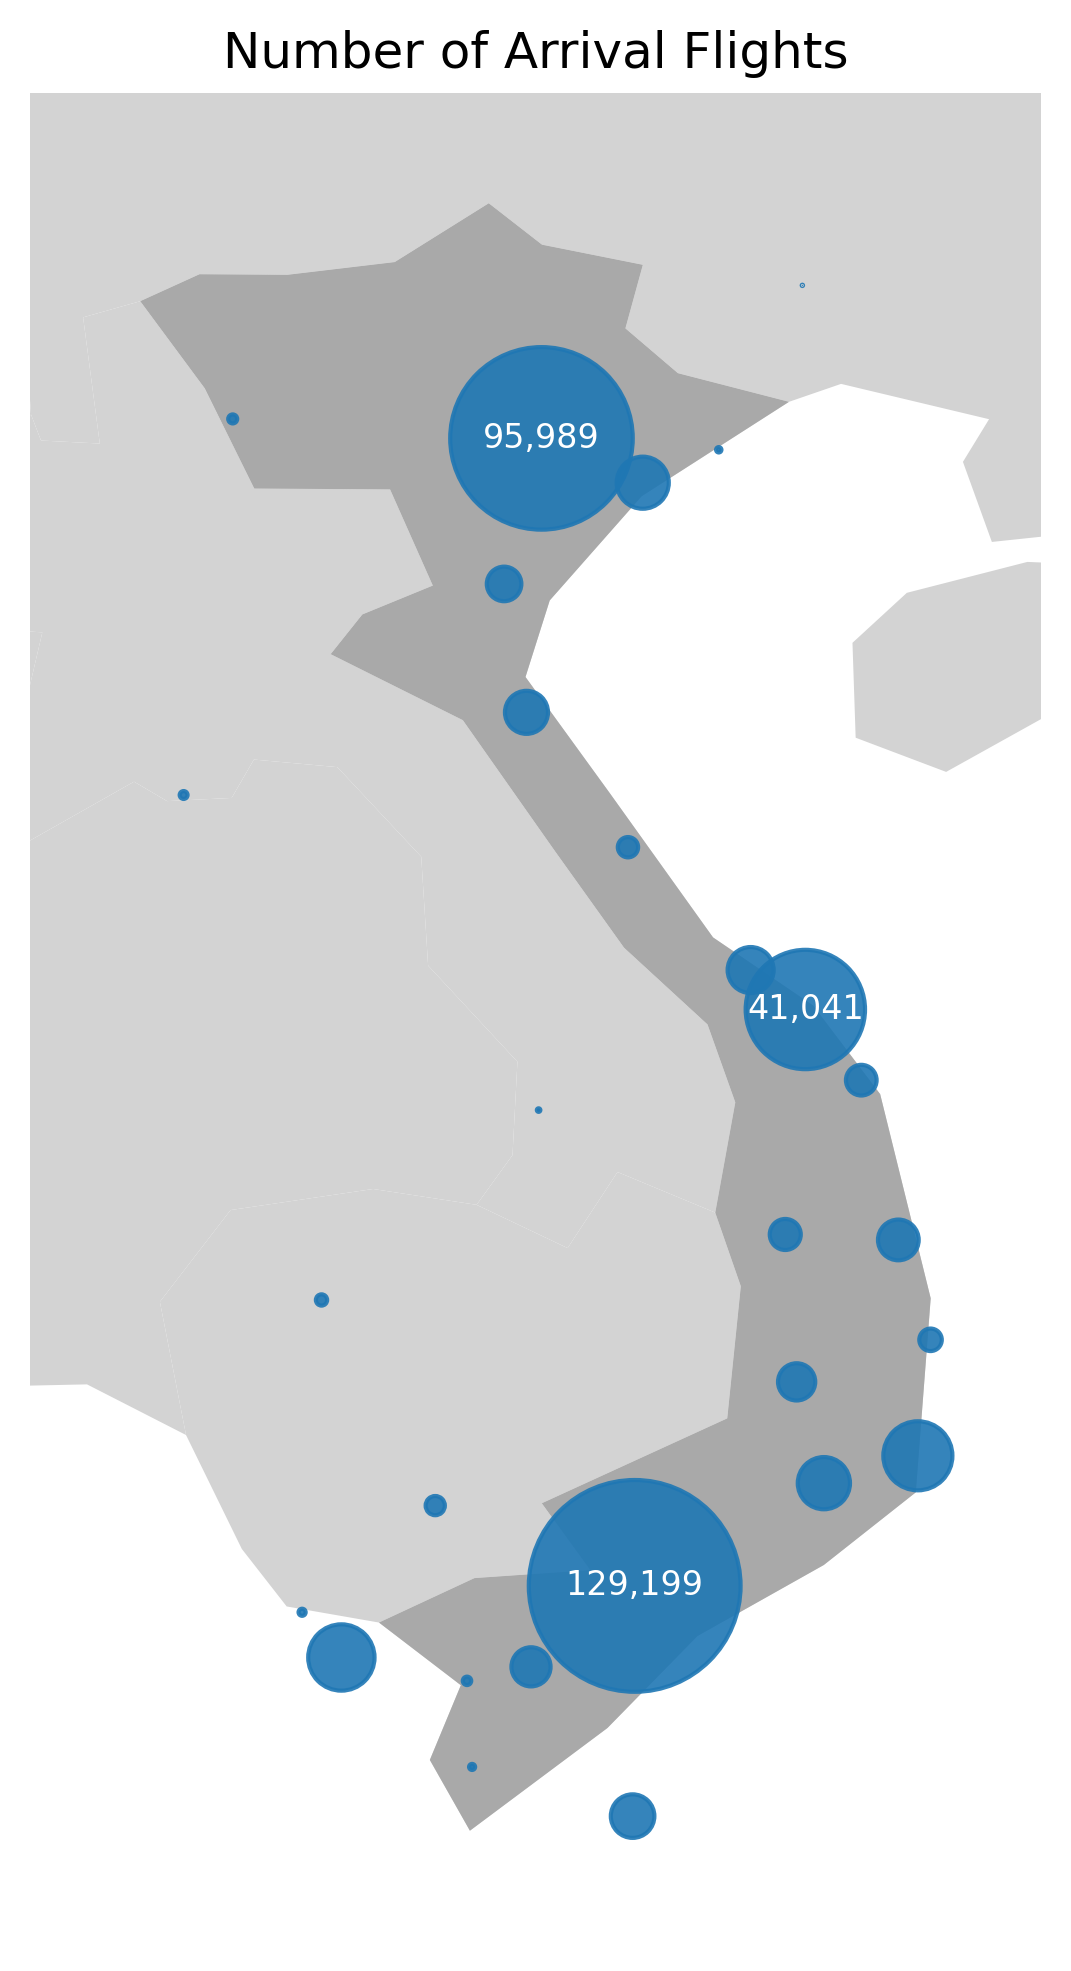

In [24]:
# Load the world map dataset & filter the area surrounding Vietnam
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
vietnam = world[world['name'] == 'Vietnam']
bbox = vietnam.total_bounds 

# Plot the world map
fig, ax = plt.subplots(figsize=(8, 8))
world.plot(ax=ax, color='lightgray')
vietnam.plot(ax=ax, color='darkgray')

# Filter flights to Vietnam
data_flt = data[(data['arr_latitude'] >= bbox[1]) & (data['arr_latitude'] <= bbox[3]) &
                (data['arr_longitude'] >= bbox[0]) & (data['arr_longitude'] <= bbox[2])]

# Count the number of data points at each longitude and latitude
data_counts = data_flt.groupby(['arr_longitude', 'arr_latitude']).size().reset_index(name='counts')

# Create a GeoDataFrame from the count data
geometry = gpd.points_from_xy(data_counts['arr_longitude'], data_counts['arr_latitude'])
gdf = gpd.GeoDataFrame(data_counts, geometry=geometry)

# Sort the data by counts in descending order
gdf = gdf.sort_values(by='counts', ascending=False)

# Plot with marker size based on the logarithm of counts
gdf['scaled_size'] = gdf['counts'].apply(lambda x: x * 0.02)  # Add 1 to avoid log(0)
gdf.plot(ax=ax, markersize=gdf['scaled_size'], alpha=0.9, legend=True)

# Annotate the top three locations with the number of flights
for i in range(3):
    ax.text(gdf.iloc[i]['arr_longitude'], gdf.iloc[i]['arr_latitude'],
            '{:,}'.format(gdf.iloc[i]['counts']), fontsize=8, ha='center', va='center', color='white')

# Set axis limits to the bounding box of Vietnam
ax.set_xlim(bbox[0]-1, bbox[2]+1)
ax.set_ylim(bbox[1]-1, bbox[3]+1)

# Set plot title and show the plot
plt.title('Number of Arrival Flights')
plt.axis('off')
plt.show()